# 14. 다대다 관계 구현하기
___
## Tag 모델 만들기
태그와 카테고리는 비슷하지만 한 포스트를 여러 태그에 연결할 수 있다는 점이 카테고리와 다르다.  

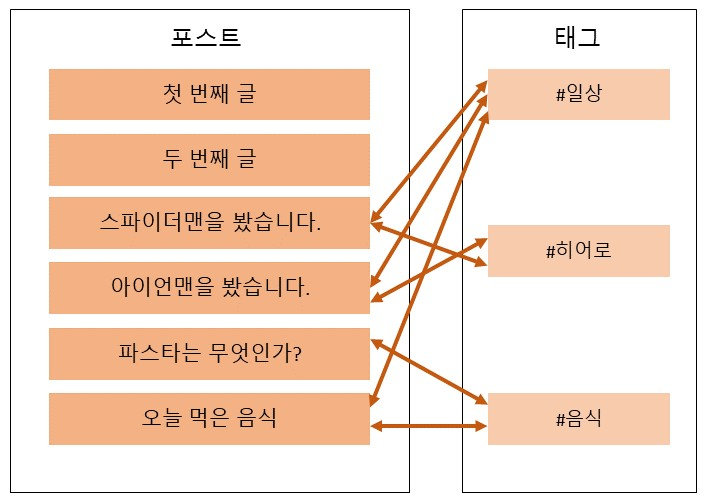

In [3]:
from IPython.core.display import Image, display,HTML
Image("images\many to many.jpg", width=600)

이런 관계를 장고는 ManyToManyField를 사용하여 구현할 수 있다. 이걸 활용해 Tag모델을 만들어 보자.

### Tag 모델 구현하기
#### (1) models.py에 Tag 모델 작성하기
Tag모델은 Category모델과 동일하다. 

In [5]:
class Tag(models.Model):
    name=models.CharField(max_length=50, unique=True)
    slug=models.SlugField(max_length=200, unique=True, allow_unicode=True)
    
    def __str__(self):
        return self.name

    def get_absolute_url(self):
        return f'/blog/tag/{self.slug}/'

NameError: name 'models' is not defined

Post 모델에도 tags 필드를 추가한다. ForeignKey가 아닌 ManyToManyField를 사용해 Tag 모델을 연결한다. tags 필드를 빈 칸으로 남겨둘 수 있도록   
null=True와 blank=True로 설정한다. on_delete=models.SET_NULL은 설정하지 않는다. 연결된 태그가 삭제되면 해당 포스트의 tags필드가 알아서 빈칸으로 바뀐다.  
Post 클래스의 아래에 아래의 코드를 추가해준다.

In [6]:
tags=models.ManyToManyField(Tag, null=True, blank=True)

NameError: name 'models' is not defined

migrations을 해보면 'null has no effect on ManyToManyField' 라는 경고가 뜬다. ManyToManyField의 default값으로 null=True이므로 효과가 없다는 뜻이다.  
해당 코드를 삭제하면 마이그레이션이 잘된다.
> ManyToManyField에 null=True 설정이 되어 잇는 이유 :  
ManyToManyField로 만드는 태그는 다대다 관계를 가진다. 즉, 하나의 포스트가 여러 태그와 연결되고, 반대로 하나의 태그가 여러 포스터와 연결될 수 도 잇다. 이때 태그 하나가 DB에서 삭제되었다고 연결된 모든 포스트가 삭제되면 안되므로 기본적으로 null 값은 True되어있다.  
#### (2) 관리자 페이지에 태그 추가하기
관리자 페이지에서도 태그를 사용할 수 있게 해보자. 먼저 models.py에서 만들었던 Tag모델을  사용하기 위해 import해준 뒤, CategoryAdmin을 응용해서 만들어주자.  

In [8]:
class TagAdmin(admin.ModelAdmin):
    prepopulated_fields={'slug':('name',)}
    
admin.site.register(Tag,TagAdmin)    

NameError: name 'admin' is not defined

admin 페이지에 정상적으로 Tags 메뉴가 생긴다.
___
## 포스트 목록과 상세 페이지에 태그 기능 추가하기
이제 포스트 목록 페이지와 상세 페이지에 태그기능을 추가해보자.
### 테스트 코드에 태그 추가하기
#### (1) tests.py에 태그 3개 추가하가.
tests.py에 코드를 추가하자. setUp 함수에 임의의 3개의 태그를  만든다.

In [9]:
# create Tags
self.tag_python_kor=Tag.objects.create(name='파이썬 공부', slag='파이썬-공부')
self.tag_python=Tag.objects.create(name='python', slug='python')
self.tag_hello=Tag.objects.create(name='hello', slug='hello')

NameError: name 'Tag' is not defined

#### (2) 태그 3개를 포스트에 연결하기
만든 태그를 포스트에 연결해보자. Post모델의 tags필드는 다른 필드들과 달리 Post.objects.create()안에 인자로 넣지 않는다. 대신 이미 만들어진 포스트에 add()함수를 추가해보자. ManyToManyField 즉, 다대다 방식은 여러개의 레코드를 연결할 수 있기 때문이다. self.post_001에는 'hello' 태그만, self.post_002에는 아무 태그도 달지않고 self.post_003에는 'python' 태그와 '파이썬 공부' 태그 2개를 달아주자.

In [10]:
self.post_001.tags.add(self.tag_hello)
self.post_003.tags.add(self.tag_python_kor)
self.post_003.tags.add(self.tag_python)

NameError: name 'self' is not defined

### 포스트 목록 페이지에 태그 기능 추가하기
포스트 카드 아래부분에 연결된 태그가 노출 되도록 해보자.
#### (1) 테스트 코드 수정하기
test_post_list() 함수에는 3개의 포스트 카드에 우리가 원하는 내용이 있는지 화인하는 테스트 코드가 있다. 여기에 포스트별로 각기 다르게 추가한 태그가 잘 출력되는지 확인하는 내용을 추가한다.  

- post_001_card에는 'hello'라는 단어가 있는지, 그리고 'python'이나 '파이썬 공부' 라는 문구는 나타나지 않아야 한다.
- post_002_card에는 어떤 태그도 없어야 한다. 
- post_003_card에는 'python'과 '파이썬 공부' 라는 문구가 둘다 존재해야한다.  

이를 코드로 구현하면 아래와 같다.

In [11]:
self.assertIn(self.tag_hello.name,post_001_card.text)
self.assertNotIn(self.tag_python.name,post_001_card.text)
self.assertNotIn(self.tag_python_kor.name,post_001_card.text)

self.assertNotIn(self.tag_hello.name,post_002_card.text)
self.assertNotIn(self.tag_python.name,post_002_card.text)
self.assertNotIn(self.tag_python_kor.name,post_002_card.text)

self.assertNotIn(self.tag_hello.name,post_003_card.text)
self.assertIn(self.tag_python.name,post_003_card.text)
self.assertIn(self.tag_python_kor.name,post_003_card.text)

NameError: name 'self' is not defined

아직 post_list.html에 tag를 넣지 않았으므로 test는 오류가 난다. post_list.html의 Post부분 에 일단 아래와 같은 코드를 추가한다.

In [13]:
{% if p.tags.exists %}
    <i class="fas fa-tag"></i>
    {% for tag in p.tags.iterator %}
        <a href="{{tag.get_absolute_url}}">
            <span class="badge rounded-pill bg-light text-dark">{{tag}}</span>
        </a>
    {% endfor %}
    <br/>
    <br/>
{% endif %}

SyntaxError: invalid syntax (<ipython-input-13-eaa34a9c2d6b>, line 1)

이 코드는 포스트에 tags 필드가 비어 있지 않은지 확인한다. 비어 있지 않다면 Read More 버튼 바로 위에 태그를 하나씩 출력한다.  
for문을 이용해 해당 포스트의 모든 태그를 반복 출력한다. 뱃지는 a 태그로를 활용해 태그 페이지로도 이동할 수 있게 하였다.  
그리고 ReadMore 버튼과 거리를 좀 둘 수 있게 줄을 추가하였다. 이제 테스트가 정상적으로 통과하는 것을 알 수 있다.
### 포스트 상세 페이지에 태그 기능 추가
포스트 상세 페이지에 추가할 태그도 목록 페이지와 동일하다.
#### (1) 테스트 코드 수정
테스트 내용은 단순하다. post_area에 self.tag_hellp의 name인 'hello'가 존재하는지, 다른 태그들은 존재하지 않는지 확인하면 된다. 아래 코드를 추가하자.

In [15]:
self.assertIn(self.tag_hello.name,post_area.text)
self.assertNotIn(self.tag_python.name,post_area.text)
self.assertNotIn(self.tag_python_kor.name,post_area.text)    

NameError: name 'self' is not defined

#### (2) 템플릿 수정하기
test를 통과하기 위해 post_detail.html을 수정하자. post_list.html의 태그 코드를 복사하고 p를 post로 수정하면된다. 
___
## 태그 페이지 만들기
앞서만든 카테고리 페이지 처럼 태그 페이지를 만들어 보자. 태그를 클릭하면 해당 태그가 달린 포스트만 모아서 목록으로 보여주는 페이지를 만들며 ㄴ된다.
### 태그 페이지 만들기
#### (1) 테스트 코드 작성
1. tests.py에 test_tag_page()함수를 새로 만든다. 먼저 테스트할 페이지는 setUp 함수에서 가져오는데 name 필드가 'hello'인 것으로 가져오자.  
2. 네비바와 카테고리 테스트 함수는 이전에 만들걸 재활용한다.  
3. 메인 영역에 'hello'가 존재하는지, 이 태그가 부턴 self.post_001의 타이틀이 존재하는지 확인한다.
4. 'hello' 태그를 사용하지 않는 self.post_002와 self.post_003의 타이틀은 메인 영역에 보이면 안된다. 

In [16]:
def test_tag_page(self):
    response=self.client.get(self.tag_hello.get_absolute_url())
    self.assertEqual(response.status_code, 200)
    soup=BeautifulSoup(response.content, 'html.parser')

    self.navbar_test(soup)
    self.category_card_test(soup)

    self.assertIn(self.tag_hello.name, soup.h1.text)

    main_area=soup.find('div', id='main-area')
    self.assertIn(self.tag_hello.name, main_area.text)

    self.assertIn(self.post_001.title, main_area.text)
    self.assertNotIn(self.post_002.title, main_area.text)
    self.assertNotIn(self.post_003.title, main_area.text)

#### (2) URL 지정하기
앞에서 models.py에서 Tag모델을 만들 때 get_absolute_url()함수에서 반환하는 URL 경로의 형태를 'blog/tag/self.slug/' 로 지정했다. 그리고 slug필드는 고유값을 갖도록 unique를 True로 설정 해주었다. 이제 태그 페이지가 존재할 수 있게 urls.py에 이 URL을 추가해주면 된다. 

In [17]:
path('tag/<str:slug>/',views.tag_page)

NameError: name 'path' is not defined

view.py의 tag_page() 함수를 사용할 수 있게 FBV스타일로 만들어주자. 먼저 URL 인자로 넘어온 slug와 동이한 slug를 가진 태그를 쿼리셋으로 가져와 tag에 저장한다. 그리고 가져온 태그에 연결할 포스트 전체를 post_list에 저장한다. 이렇게 쿼리셋으로 가져온 인자를 render()함수안에 dic 형태로 담고 마지막으로 테그 페이지 오른쪽에도 카테고리 카드를 보여주기 위해 categories와 no_category_post_count도 추가해준다.

In [18]:
def category_page(request, slug): # 1. 매개변수 설정
    # 카테고리가없는경우
    if slug=='no_category':
        category='미분류'
        post_list=Post.objects.filter(category=None)
    else:
        category=Category.objects.get(slug=slug)
        post_list=Post.objects.filter(category=category)
    
    return render(
        request,
        'blog/post_list.html',  # 2. 템플릿은 포스트 목록 페이지 사용
        {#3. 딕셔너리 정의
        'post_list' : post_list,
        'categories' : Category.objects.all(),
        'no_category_post_count' : Post.objects.filter(category=None).count(),
        'category' : category,
        }
    )

#### (3) 뷰 수정하기
해당 태그가 존재할 때 태그 페이지 화면에 뱃지를 보여 줄수 있게 수정하면 테스트를 통과한다.

In [19]:
{% if tag %}
        <span class="badge bg-dark">{{ tag }}</span>
{% endif %}

SyntaxError: invalid syntax (<ipython-input-19-58e630145b7e>, line 1)

#### (4) 템플릿 수정하기
웹브라우저를 열어보면 보이는 문제점은 태그 페이지와 포스트 페이지의 뱃지가 똑같아서 구별이 가지 않는다. 아이콘도 붙어주고 색도 바꿔주자.